# ANN Course Project by ANKIT SHARMA (24/AFI/05)

### Import the required libraries

In [ ]:
import sys
sys.path.append('.')
sys.path.append('../')
import os
import os.path as path
import datetime
import pandas as pd
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import darts
from darts import TimeSeries
import cufflinks as cf
cf.go_offline()
from plotly.offline import plot, download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import display, Math, Markdown
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
%load_ext autoreload
%autoreload 2

### Load Dataset

In [ ]:
pickle_file = "/data/world_events_dataset_from_1980.pkl"

try:
    # Load the DataFrame
    with open(pickle_file, "rb") as file:
        data = pickle.load(file)

        # Check if it's a DataFrame
        if isinstance(data, pd.DataFrame):
            # Get the last 20 rows
            last_20_rows = data.tail(20)

            # Display the DataFrame in a natural table format
            from IPython.display import display
            display(last_20_rows)
        else:
            print(f"Unexpected data type: {type(data)}. Please check the file content.")
except FileNotFoundError:
    print("The specified pickle file does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

,wiki_name,date,country,Category,High-Category,ref_num,avg_num_views,embedding
16746,2020 Vermont gubernatorial election,2020-11-03,Vermont,Election,SocietalEvent,41,271.812098,"[-0.3710651, 0.64300466, 0.57575923, 0.3711877..."
16747,2020 United States presidential election in Vi...,2020-11-03,Virginia,Election,SocietalEvent,66,347.890212,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16748,2020 United States presidential election in th...,2020-11-03,"Washington,_D.C.",Election,SocietalEvent,30,152.291391,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16749,2020 United States presidential election in Wa...,2020-11-03,Washington_(state),Election,SocietalEvent,54,207.650794,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16750,2020 West Virginia gubernatorial election,2020-11-03,West Virginia,Election,SocietalEvent,66,258.052229,"[0.05111569, -0.1453084, -0.05666516, -0.33789..."
16751,2020 United States presidential election in We...,2020-11-03,West_Virginia,Election,SocietalEvent,44,187.272487,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16752,2020 United States presidential election in Wi...,2020-11-03,Wisconsin,Election,SocietalEvent,245,752.906085,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16753,2020 United States presidential election in Wy...,2020-11-03,Wyoming,Election,SocietalEvent,33,158.411376,"[-1.6172955, 0.35951188, -0.64696777, 1.898128..."
16754,2020 Myanmar general election,2020-11-08,Myanmar,Election,SocietalEvent,0,464.019481,"[0.32944024, -0.096266605, 0.51983714, -0.0546..."
16755,2020 Masters Tournament,2020-11-12,United States of America,GolfTournament,SportsEvent,40,865.785174,"[-0.33693168, 1.6073282, -0.6598441, -0.238583..."


In [12]:
df = pd.read_csv('/data/train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [16]:
df.isnull().sum()

,0
date,0
store,0
item,0
sales,0
year,0
month,0
day,0
weekday,0


### Data Preprocessing
For simplicity, we only consider the sales of 'item' - 1 from 'store' - 1. The dataset is split into train and test sets, where the train set contains sales record from January 2013 to September 2017 and the test set contains sales records of the last three month of 2017.


In [13]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


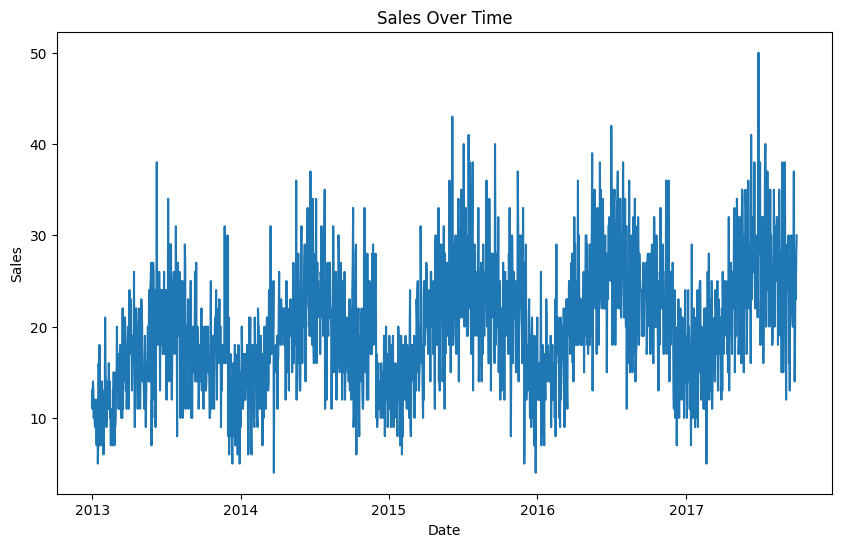

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_df['date'], train_df['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
_ = plt.title('Sales Over Time')

In [ ]:
test_df.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,1,21,2017,10,1,6
1,2017-10-02,1,1,12,2017,10,2,7
2,2017-10-03,1,1,18,2017,10,3,1
3,2017-10-04,1,1,15,2017,10,4,2
4,2017-10-05,1,1,20,2017,10,5,3


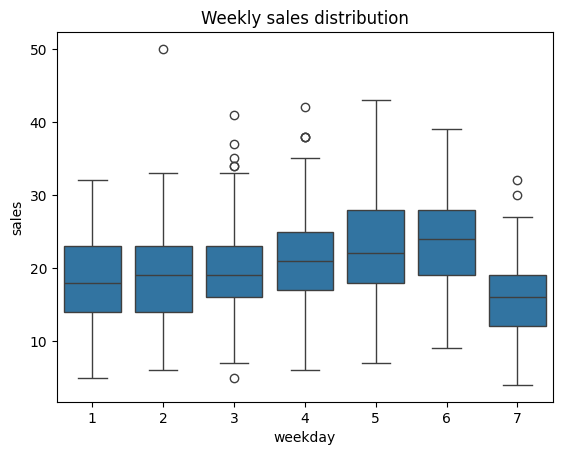

In [ ]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

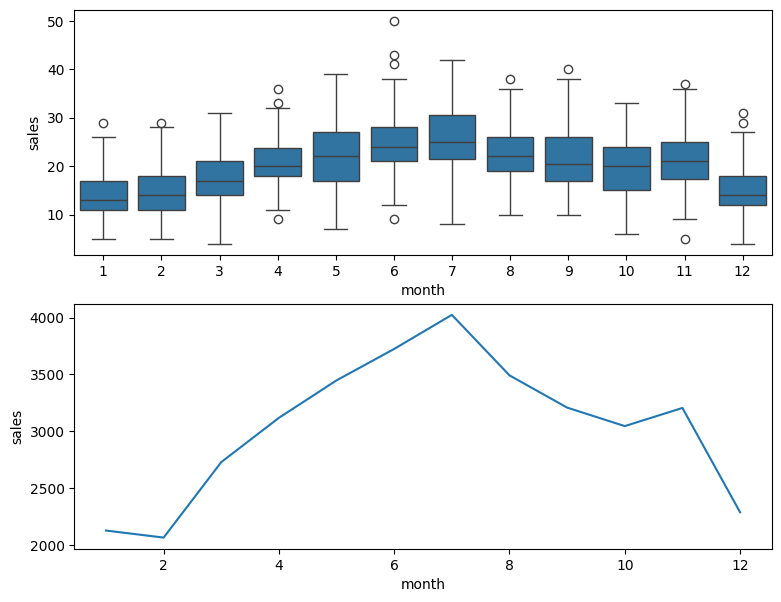

In [ ]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

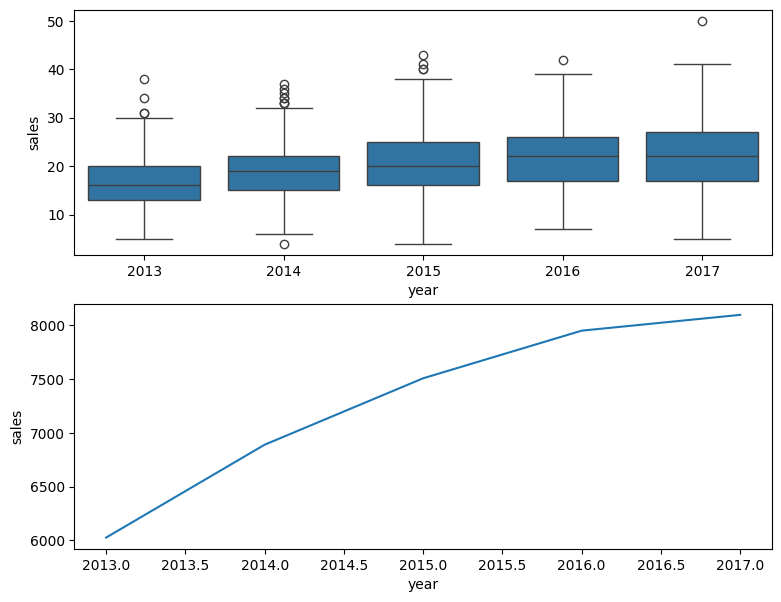

In [ ]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

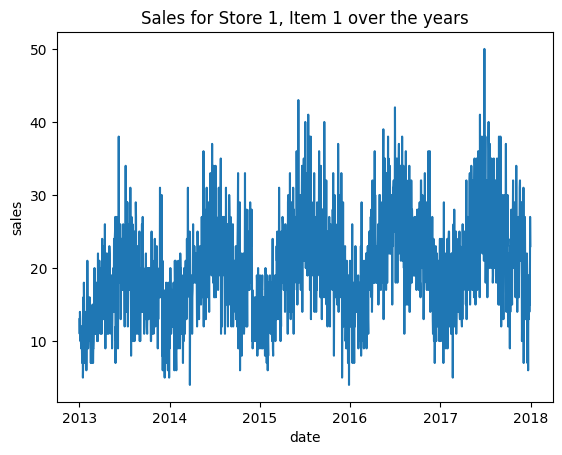

In [ ]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

In [ ]:
from demand_prediction.general_functions import get_file_path, get_df_table, load_table_cache, save_table_cache, get_pred_dates
from demand_prediction.dataset_functions import split_data, create_events_df
from demand_prediction.ts_models import train_models, test_models, save_model, load_model
from demand_prediction.events_models import load_events_model, save_events_model, calc_events_ts
from demand_prediction.neural_prophet_model import NeuralProphetEvents, reformat_events_name, get_events_for_neural_prophet, get_neural_prophet_results
from demand_prediction.lstm_models import get_lstm_results
from demand_prediction.tcn_models import get_tcn_results
from demand_prediction.results_functions import get_all_k_metrics

Global seed set to 0


In [ ]:
dates_example = pd.date_range("2013-01-01", "2018-01-01",freq='d')
values_example = np.random.randint(100,2000,size=(len(dates_example)))
categ_data = pd.DataFrame({'date': dates_example, 'Quantity': values_example})
categ_data.index = categ_data['date']
categ_data = categ_data.drop(columns=['date'])

In [ ]:
ts_cache = True
neural_cache = True
lstm_cache = True
lstm_df_cache = True
tcn_cache = True
tcn_df_cache = True
results_cache = True

n_in = 365
window_size = 2
prediction_time = 30

device = 'cpu'

In [ ]:
total_pred = pd.DataFrame()
start_pred_list = get_pred_dates('2013-01-01', '2018-01-01')

for start_pred_time in tqdm(start_pred_list):
    pred_path = final_results + leaf_name  + str(start_pred_time)
    if pred_path and os.path.isfile(pred_path):
        total_pred = pd.read_pickle(pred_path)

    else:
        X_train, X_test = split_data(data, start_pred_time)
        time_series = TimeSeries.from_dataframe(categ_data, value_cols='Quantity')
        train, test_ts = time_series.split_before(pd.Timestamp(start_pred_time))
        test = test_ts[:prediction_time]
        events_all = pd.concat([X_train, X_test])
        train_df, test_df = train.pd_dataframe(), test.pd_dataframe()
        train_dates, test_dates = train_df.index.values, test_df.index.values

        res_prediction = test_models(test, test_name=leaf_name, start_pred_time=start_pred_time, train=train, use_cache=ts_cache)
        lstm_predictions = get_lstm_results(train, test, train_df, test_df, events_all, start_pred_time, leaf_name, n_in, window_size, categ_data, device, lstm_df_cache, lstm_cache)
        tcn_predictions = get_tcn_results(train, test, train_df, test_df, events_all, start_pred_time, leaf_name, n_in, window_size, categ_data, device, tcn_df_cache, tcn_cache)
        neural_predictions = get_neural_prophet_results(train, test, events_all, leaf_name, events_dates, start_pred_time, neural_cache)

        total_pred = pd.concat([total_pred, pd.concat([res_prediction, lstm_predictions, tcn_predictions, neural_predictions], axis=1)])
        os.makedirs(os.path.dirname(pred_path), exist_ok=True)
        total_pred.to_pickle(pred_path)

100%|██████████| 1/1 [00:00<00:00, 193.05it/s]


In [ ]:
leaf_name = 'Football Cards'

<Figure size 640x480 with 0 Axes>

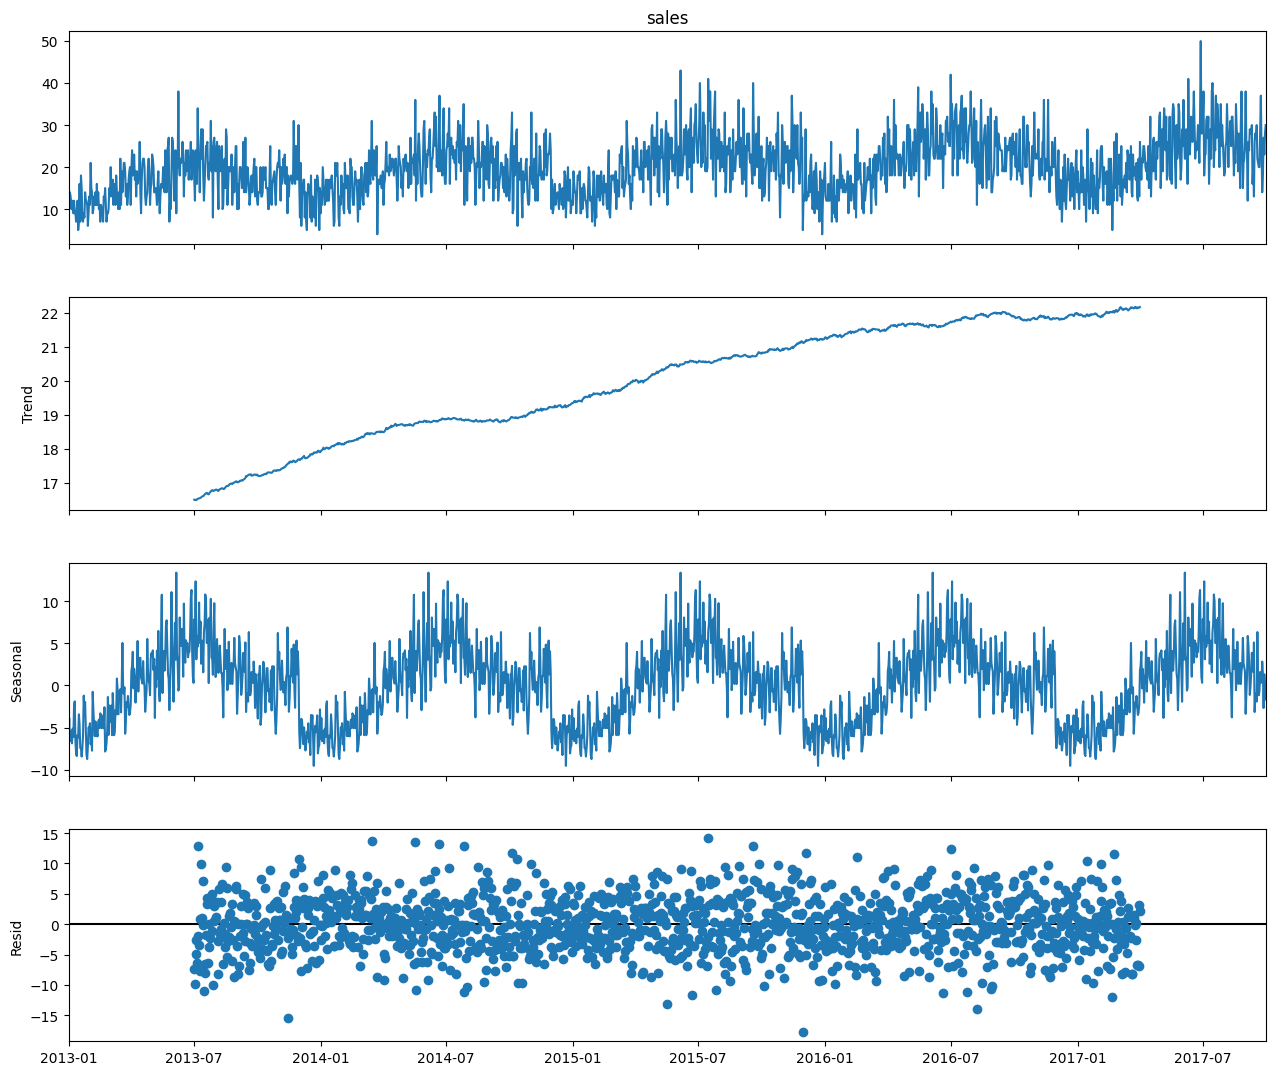

In [ ]:
result = pd_decompose(ts_decomp_df['sales'], model='additive', period=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

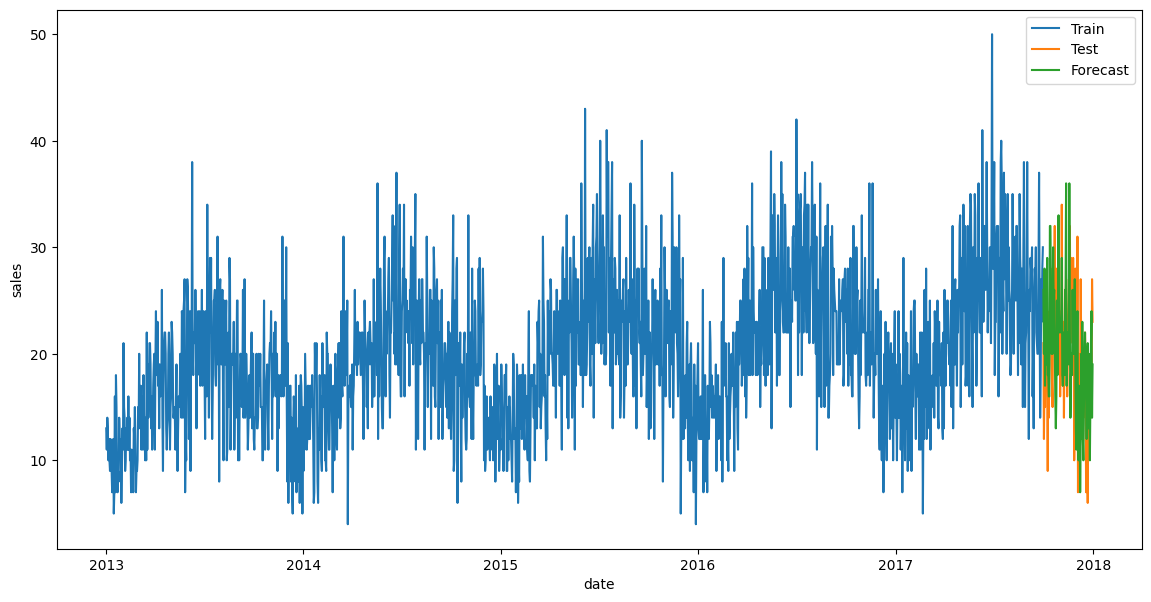

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['sales'], label='Forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

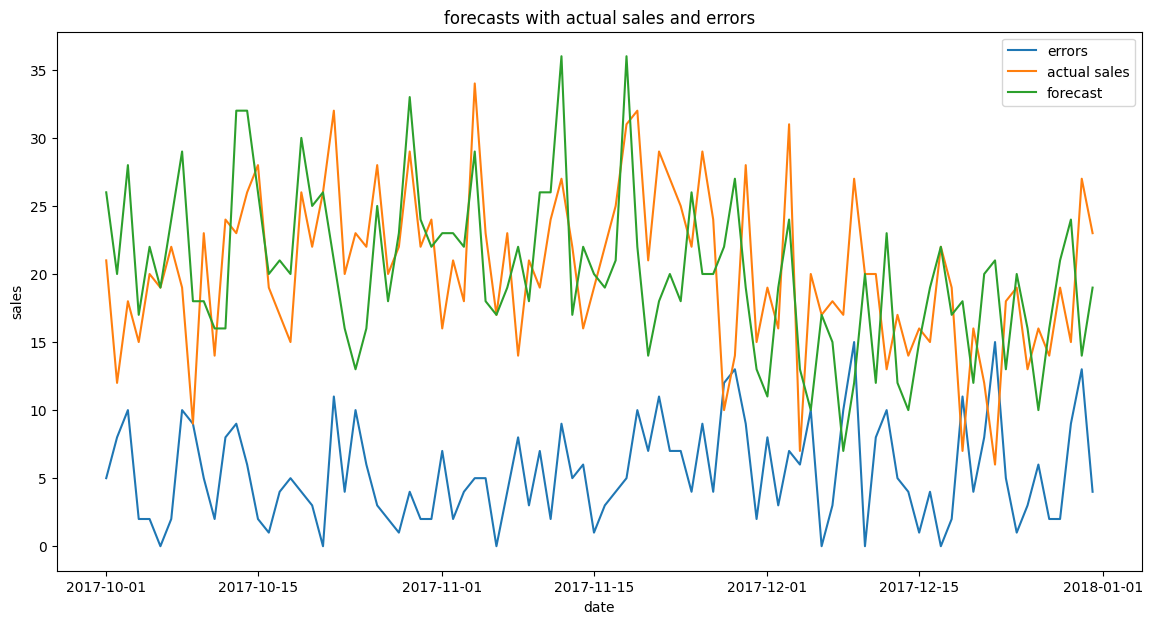

In [ ]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'pd_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'pd_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['pd_sales']
errors_df.insert(0, 'model', 'sales')

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('pd_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae),
                                           RMSE=('errors', rmse),
                                           MAPE=('errors', mape))


plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['pd_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('forecasts with actual sales and errors')
plt.show()


In [ ]:
total_pred = total_pred[total_pred.index >= start_pred_list[0]]
pred_df = total_pred[['Real Quantity', 'LSTM', 'GAN - Event LSTM', 'Event LSTM', 'Weighted Event LSTM', 'ARIMA', 'Prophet', 'NeuralProphet', 'GAN - Event CNN']]

In [ ]:
get_all_k_metrics(total_pred)

,ARIMA,Prophet,NeuralProphet,LSTM,Event LSTM,GAN - Event LSTM,Weighted Event LSTM,GAN - Event CNN,Event NeuralProphet
MAE@5,731,998,2347,1646,909,1025,872,1395,2313
MAE@10,524,832,1862,1438,722,833,712,1191,1774
MAE@20,374,504,1655,1081,464,511,473,852,1682
wMAPE@5,0.42,0.573,1.347,0.945,0.522,0.589,0.501,0.801,1.328
wMAPE@10,0.341,0.542,1.213,0.937,0.47,0.543,0.464,0.776,1.156
wMAPE@20,0.318,0.428,1.407,0.919,0.394,0.434,0.402,0.725,1.43
